In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import KFold
from utils_plot import *
from scipy.optimize import minimize_scalar
from scipy.stats import spearmanr, pearsonr
import json

In [2]:
# 1. Data Normalization

def preprocessing(alpha1, alpha2, N, ampl_threshold=0.2):

    targetnames = np.array(sorted(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    N_norm = N - np.mean(N, axis=0, keepdims=True)

    return alpha1_norm, alpha2_norm, N_norm, targetnames_filtered, tf_names_filtered

In [3]:
def standardize_amplitudes(matrices, target_amp=0.2):
    """
    Rescale the matrices to a single target amplitude.
    """
    standardized_matrices = []
    for matrix in matrices:
        amp = (np.max(matrix, axis=1) - np.min(matrix, axis=1)) / 2
        scale = target_amp / amp
        standardized_matrix = matrix * scale[:, np.newaxis]
        standardized_matrices.append(standardized_matrix)
    
    return standardized_matrices

In [4]:
def svd_regression_with_lambda_CV(alpha, N, lambdas, n_splits=5, random_state=42):
    """
    Perform regression using SVD and select best regularization parameter (lambda)
    using k-fold Cross-Validation, following ISMARA approach.
    """
    # Get dimensions
    G, M = N.shape
    C = alpha.shape[1]
    
    # Perform SVD once
    U, s, VT = np.linalg.svd(N, full_matrices=False)
    
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Metrics storage
    val_errors = np.zeros((len(lambdas), n_splits))
    val_explained_variances = np.zeros((len(lambdas), n_splits))
    train_explained_variances = np.zeros((len(lambdas), n_splits))
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(G))):
        # Prepare matrices for this fold
        U_train = U[train_idx, :]
        alpha_train = alpha[train_idx, :]
        M_train = U_train.T @ alpha_train
        
        U_val = U[val_idx, :]
        alpha_val = alpha[val_idx, :]
        
        # Test each lambda value
        for i, lambd in enumerate(lambdas):
            # Calculate shrinkage factors
            shrink = s / (s**2 + lambd)
            
            # Get A_star for this lambda using training data
            A_star = VT.T @ (shrink[:, None] * M_train)
            
            # Make predictions
            R_train = N[train_idx, :] @ A_star
            R_val = N[val_idx, :] @ A_star
            
            # Calculate metrics
            val_errors[i, fold] = mean_squared_error(alpha_val.T, R_val.T)
            val_explained_variances[i, fold] = explained_variance_score(alpha_val, R_val)
            train_explained_variances[i, fold] = explained_variance_score(alpha_train, R_train)
    
    # Average metrics across folds
    mean_val_errors = np.mean(val_errors, axis=1)
    mean_val_explained_variances = np.mean(val_explained_variances, axis=1)
    mean_train_explained_variances = np.mean(train_explained_variances, axis=1)
    
    # Find optimal lambda
    best_lambda_idx = np.argmin(mean_val_errors)
    lambda_opt = lambdas[best_lambda_idx]
    
    # Train final model on all data using optimal lambda
    shrink_opt = s / (s**2 + lambda_opt)
    M_full = U.T @ alpha
    A_star = VT.T @ (shrink_opt[:, None] * M_full)

    # Plot
    fig, ax1 = plt.subplots(figsize=(6,4))

    color = 'tab:blue'
    ax1.set_xlabel('Lambda')
    ax1.set_ylabel('Validation MSE', color=color)
    ax1.plot(lambdas, mean_val_errors, color=color, label='Validation MSE')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Explained Variance (%)')

    color = 'tab:green'
    ax2.plot(lambdas, mean_val_explained_variances * 100, color='tab:green', linestyle='--', label='Validation EV')
    ax2.plot(lambdas, mean_train_explained_variances * 100, color='tab:orange', linestyle='--', label='Training EV')
    ax2.tick_params(axis='y')

    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

    fig.suptitle('Cross-Validation: MSE and EV vs Lambda')
    fig.tight_layout()
    plt.show()

    return A_star, lambda_opt

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360)


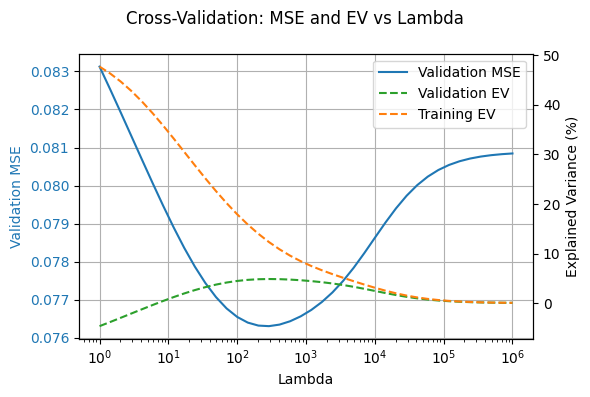

Best lambda: 289.4266124716752


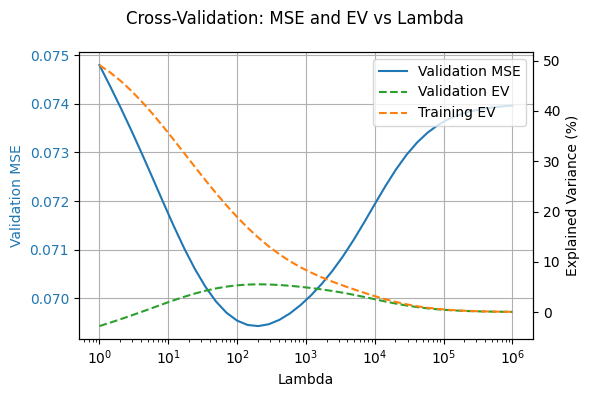

Best lambda: 203.09176209047368


In [5]:
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
lambdas = np.logspace(0, 6, 40)
random_state = 42

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape)

A_star1, lambda_opt1 = svd_regression_with_lambda_CV(alpha1_norm, N_norm, lambdas, random_state=random_state)
print("Best lambda:", lambda_opt1)
A_star2, lambda_opt2 = svd_regression_with_lambda_CV(alpha2_norm, N_norm, lambdas, random_state=random_state)
print("Best lambda:", lambda_opt2)

# Save activities (TFs × θ)
#np.save("activities_export/ampl_"+str(ampl_threshold)+"/A_star_split.npy", A_star1)
#np.save("activities_export/ampl_"+str(ampl_threshold)+"/tf_names_split.npy", np.array(tf_names))
#np.save("activities_export/ampl_"+str(ampl_threshold)+"/targetnames_split.npy", np.array(targetnames))

In [6]:
#EV at optimum lambda
print(f"EV at lambda_opt1 = {lambda_opt1:.2f}")
R1 = N_norm @ A_star1
EV_train1, EV_test1 = round(explained_variance_score(alpha1_norm, R1)*100,2), round(explained_variance_score(alpha2_norm, R1)*100,2)
print("EV_train1 :", EV_train1, "%")#, "MSE_train :", round(mean_squared_error(alpha1_norm, R),2))
print("EV_test1 :", EV_test1, "%\n")#, "MSE_test :", round(mean_squared_error(alpha2_norm, R),3))

print(f"EV at lambda_opt2 = {lambda_opt2:.2f}")
R2 = N_norm @ A_star2
EV_train2, EV_test2 = round(explained_variance_score(alpha2_norm, R2)*100,2), round(explained_variance_score(alpha1_norm, R2)*100,2)
print("EV_train2 :", EV_train2, "%")#, "MSE_train :", round(mean_squared_error(alpha1_norm, R),2))
print("EV_test2 :", EV_test2, "%\n")#, "MSE_test :", round(mean_squared_error(alpha2_norm, R),3))

print(f"EV_train_tot = {(EV_train1+EV_train2)/2:.2f}%")
print(f"EV_test_tot = {(EV_test1+EV_test2)/2:.2f}%")

EV at lambda_opt1 = 289.43
EV_train1 : 12.64 %
EV_test1 : 11.27 %

EV at lambda_opt2 = 203.09
EV_train2 : 15.13 %
EV_test2 : 11.79 %

EV_train_tot = 13.89%
EV_test_tot = 11.53%


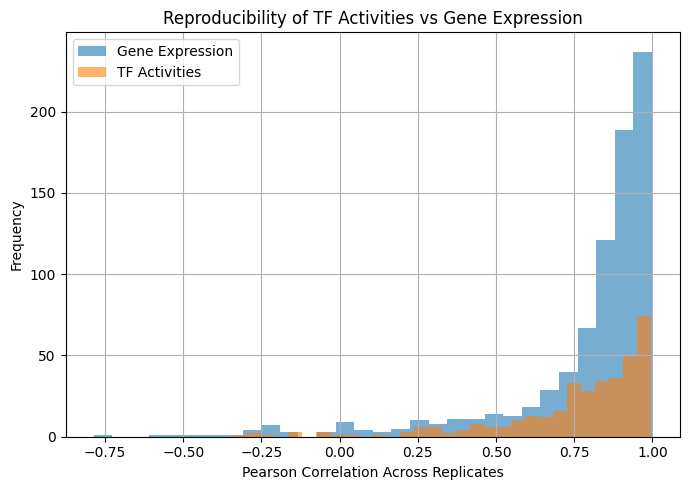

Mean correlation of expression profiles:  0.788
Mean correlation of TF activities:        0.759
Median correlation of expression:         0.886
Median correlation of TF activities:      0.84


In [7]:
def compute_reproducibility(A_star1, A_star2, alpha1_norm, alpha2_norm):
    """
    Compare reproducibility of inferred TF activities vs raw gene expression.
    
    Inputs:
        A_star1, A_star2: (TFs x theta) activity matrices from replicate 1 and 2
        alpha1_norm, alpha2_norm: (genes x theta) normalized expression data

    Outputs:
        corrs_A: Pearson correlations per TF (array of length TFs)
        corrs_E: Pearson correlations per gene (array of length genes)
    """
    n_tfs = A_star1.shape[0]
    n_genes = alpha1_norm.shape[0]

    corrs_A = np.zeros(n_tfs)
    for m in range(n_tfs):
        corrs_A[m], _ = pearsonr(A_star1[m, :], A_star2[m, :])

    corrs_E = np.zeros(n_genes)
    for g in range(n_genes):
        corrs_E[g], _ = pearsonr(alpha1_norm[g, :], alpha2_norm[g, :])

    # Plot
    plt.figure(figsize=(7, 5))
    plt.hist(corrs_E, bins=30, alpha=0.6, label='Gene Expression', color='tab:blue')
    plt.hist(corrs_A, bins=30, alpha=0.6, label='TF Activities', color='tab:orange')
    plt.xlabel('Pearson Correlation Across Replicates')
    plt.ylabel('Frequency')
    plt.title('Reproducibility of TF Activities vs Gene Expression')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print stats
    print("Mean correlation of expression profiles: ", round(np.mean(corrs_E), 3))
    print("Mean correlation of TF activities:       ", round(np.mean(corrs_A), 3))
    print("Median correlation of expression:        ", round(np.median(corrs_E), 3))
    print("Median correlation of TF activities:     ", round(np.median(corrs_A), 3))

    return corrs_A, corrs_E

corrs_A, corrs_E = compute_reproducibility(A_star1, A_star2, alpha1_norm, alpha2_norm)

In [8]:
#Downstream analysis is performed on one of the two replicates
A_star = A_star1
R = R1

In [9]:
with open('/shared/space2/molina/suttyg/gene_phase_dict.json', 'r') as f:
    d = json.load(f)
cyclic_genes = d['G1/S']+d['G2/M']
print(cyclic_genes)

['Pold3', 'Rad51', 'Pcna', 'Mcm6', 'Dtl', 'Chaf1b', 'Usp1', 'Fen1', 'Atad2', 'Mcm4', 'Rrm1', 'Rfc2', 'Casp8ap2', 'Rpa2', 'Clspn', 'Gmnn', 'Ccne2', 'E2f8', 'Hells', 'Mcm2', 'Exo1', 'Prim1', 'Rad51ap1', 'Slbp', 'Gins2', 'Msh2', 'Dscc1', 'Blm', 'Tipin', 'Rrm2', 'Cdc45', 'Mlf1ip', 'Pola1', 'Tyms', 'Ung', 'Brip1', 'Wdr76', 'Cdc6', 'Nasp', 'Uhrf1', 'Ubr7', 'Cdca7', 'Hmgb2', 'Ckap2', 'Ctcf', 'G2e3', 'Ncapd2', 'Ndc80', 'Nusap1', 'Ttk', 'Ccnb2', 'Cdc20', 'Kif20b', 'Cdc25c', 'Ube2c', 'Cenpa', 'Aurka', 'Top2a', 'Tacc3', 'Tubb4b', 'Kif11', 'Ect2', 'Gas2l3', 'Cbx5', 'Nek2', 'Hjurp', 'Hn1', 'Cenpf', 'Cks1b', 'Bub1', 'Cks2', 'Psrc1', 'Kif23', 'Ckap2l', 'Aurkb', 'Mki67', 'Kif2c', 'Tmpo', 'Gtse1', 'Nuf2', 'Dlgap5', 'Lbr', 'Hmmr', 'Tpx2', 'Fam64a', 'Rangap1', 'Anp32e', 'Cdca8', 'Cdca3', 'Anln', 'Cdk1', 'Cdca2', 'Smc4']


In [10]:
#Check EV for known cyclic genes
#cyclic_genes = ["Nusap1", "Tpx2", "Kif11", "Ccnb1", "Cdk1", "Cdc20", "Top2a", "Cenpe", "Aurka", "Anln", "Prc1", "Pcna", "Mcm2", "Mcm3", "Mcm4", "Mcm5", "Mcm6", "Cdc6", "Rrm1", "Rrm2", "Ect2", "Ccne1", "Ccne2", "Cdc25a", "Chek1", "Cdc25c"]
EVs = []
c = 0
for cyclic_gene in cyclic_genes:
    try:
        n = np.where(targetnames == cyclic_gene)[0][0]
        EV = round(explained_variance_score(alpha1_norm[n, :], R[n, :])*100,2)
        EVs.append(EV)
    except:
        c += 1
print(len(cyclic_genes)-c, "/",len(cyclic_genes), "genes in the list.")
EVs = np.array(EVs)
print(round(np.mean(EVs), 2), "% (proportion of pos EV :", round(np.sum(EVs > 0)/len(EVs)*100, 2), "%)")

53 / 93 genes in the list.
24.24 % (proportion of pos EV : 86.79 %)


68.42 %


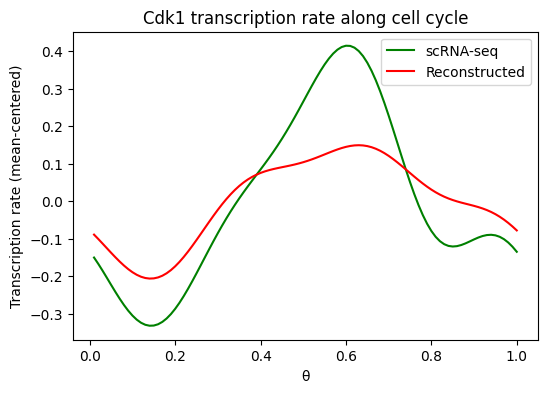

In [11]:
n = np.where(targetnames == 'Cdk1')[0][0]
#n = 6
#print("Train")
print(round(explained_variance_score(alpha1_norm[n, :], R[n, :])*100,2), "%")
plot_rate_comparison(targetnames, alpha1_norm, R, process, theta_smooth, target_nb=n)
#print("Test")
#plot_rate_comparison(targetnames, alpha2_norm, R, process, theta_smooth, target_nb=n)

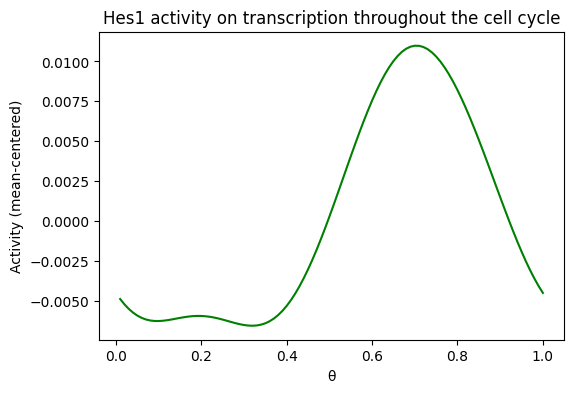

In [12]:
BP_nb = np.where(tf_names == 'Hes1')[0][0]
plot_binding_protein_activity(tf_names, A_star, process, theta_smooth, BP_nb=BP_nb)

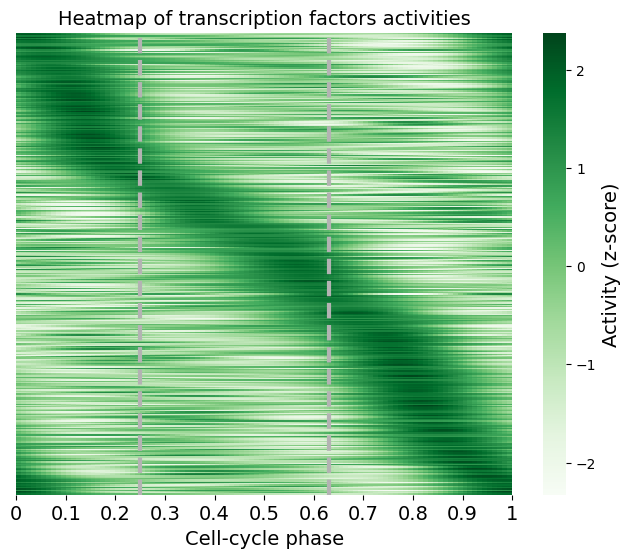

In [13]:
#Heatmap of BPs activity along cell cycle
#tf_displayed = plot_heatmap(A_star, ylabels=tf_names, display_limit=20, cmap='Greens')
tf_displayed = plot_heatmap(A_star, cmap="Greens")
#print(tf_displayed)

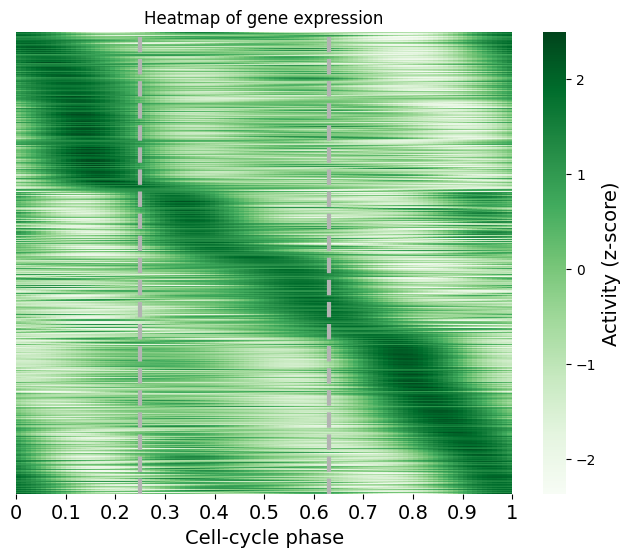

In [14]:
#Heatmap of BPs activity along cell cycle
#gene_displayed = plot_heatmap(alpha1_norm, ylabels=targetnames, display_limit=20)
gene_displayed = plot_heatmap(alpha1_norm, title="gene expression", cmap="Greens")
#print(tf_displayed)

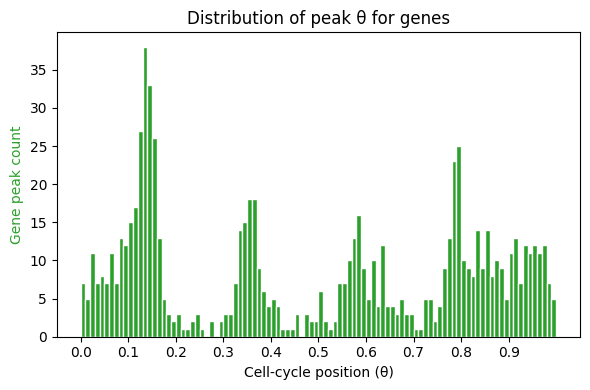

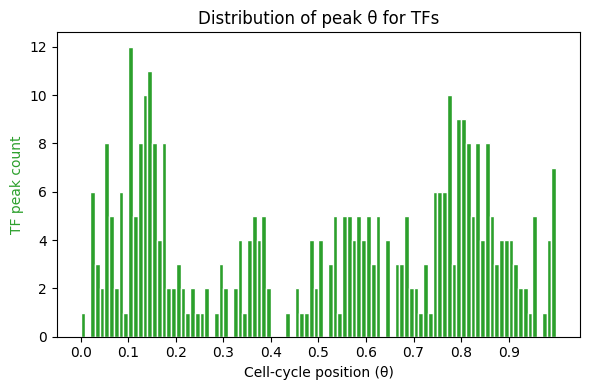

In [15]:
def plot_peak_histogram_dual_axis(alpha, A):
    """
    Plot a histogram of the theta‐positions at which genes and TFs reach their peak,
    with separate y‐axes (left for genes, right for TFs).
    """
    num_thetas = alpha.shape[1]
    theta      = np.linspace(0, 1, num_thetas)
    bins       = np.arange(num_thetas + 1)

    # 1) Gene peaks
    gene_peaks = np.argmax(alpha, axis=1)
    plt.figure(figsize=(6, 4))
    plt.hist(gene_peaks, bins=bins, color='tab:green', edgecolor='white')
    plt.title('Distribution of peak θ for genes')
    plt.ylabel('Gene peak count', color='tab:green')
    plt.xlabel('Cell‐cycle position (θ)')
    ticks = np.arange(0, num_thetas, max(1, num_thetas // 10))
    plt.xticks(ticks, [f"{theta[i]:.1f}" for i in ticks])
    plt.tight_layout()
    plt.show()

    # 2) TF peaks
    tf_peaks = np.argmax(A, axis=1)
    plt.figure(figsize=(6, 4))
    plt.hist(tf_peaks, bins=bins, color='tab:green', edgecolor='white')
    plt.title('Distribution of peak θ for TFs')
    plt.ylabel('TF peak count', color='tab:green')
    plt.xlabel('Cell‐cycle position (θ)')
    plt.xticks(ticks, [f"{theta[i]:.1f}" for i in ticks])
    plt.tight_layout()
    plt.show()
    
#plot_peak_theta_vs_index(alpha1_norm, A_star)
plot_peak_histogram_dual_axis(alpha1_norm, A_star)

In [16]:
expected_activity = {
    "Smad3": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "Hbp1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "E2f1": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f2_E2f5": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f3": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f4": {"ranges": [(0.01, 0.25)], "inhibitory": False}, #May be True
    "E2f6": {"ranges": [(0.01, 0.25), (0.63, 0.9)], "inhibitory": False}, #May be True
    "E2f7": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "E2f8": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "Sp1": {"ranges": [(0.1, 0.63)], "inhibitory": False},
    "Hes1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    #"Elf3": {"ranges": [(0.25, 1)], "inhibitory": False},
    #"Tfap4": {"ranges": [(0.63, 0.9)], "inhibitory": False}
}

In [17]:
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2", "E2f3", "E2f4", "E2f5", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1"]

fileAlphaTF_sn1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlphaTF_sn2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"

#Get spliced RNA data to compare splicing and protein activity dynamics
alpha_sn1 = pd.read_csv(fileAlphaTF_sn1, sep=",",index_col=0)
alpha_sn2 = pd.read_csv(fileAlphaTF_sn2, sep=",",index_col=0)

tf_names_filtered = np.array([tf for tf in key_tfs if tf in alpha_sn1.index and tf in alpha_sn2.index and tf in tf_names])
print("TFs in common :", str(len(tf_names_filtered))+"/"+str(len(key_tfs)))

alpha_sn1_f, alpha_sn2_f = alpha_sn1.loc[tf_names_filtered], alpha_sn2.loc[tf_names_filtered]
alpha_sn1_n, alpha_sn2_n = alpha_sn1_f.to_numpy(), alpha_sn2_f.to_numpy()

#Standardize amplitudes
#A_standard = A_standard - np.mean(A_standard, axis=1, keepdims=True)
alpha_sn_n = (alpha_sn1_n + alpha_sn2_n) / 2
alpha_sn_norm = alpha_sn_n - np.mean(alpha_sn_n, axis=1, keepdims=True) - np.mean(alpha_sn_n, axis=0, keepdims=True) + np.mean(alpha_sn_n)
alpha_sn_norm, A_standard = standardize_amplitudes([alpha_sn_norm, A_star])

TFs in common : 10/12


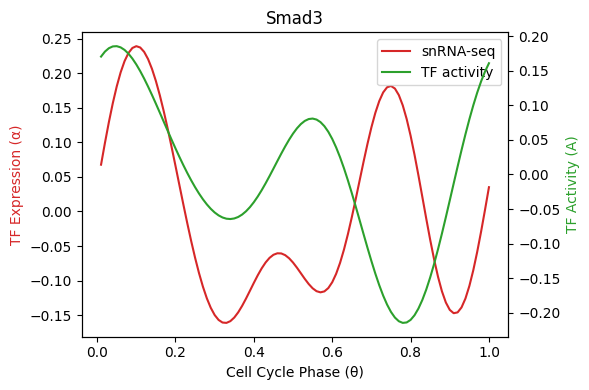

scRNA & A correlation : -0.189 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -4.42 (inhibitor)


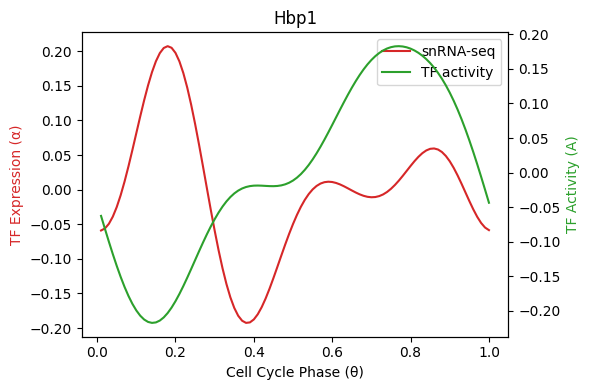

scRNA & A correlation : 0.104 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 15.15 (inhibitor)


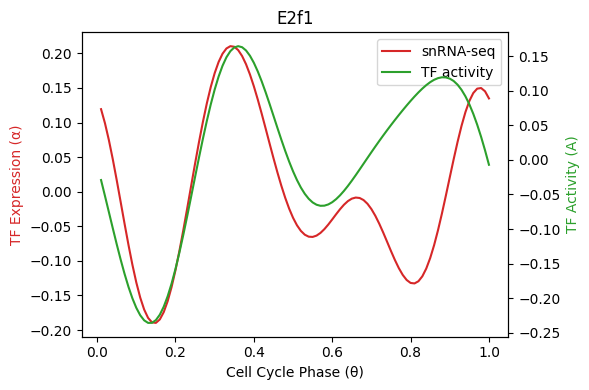

scRNA & A correlation : 0.567 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -2.06 (activator)


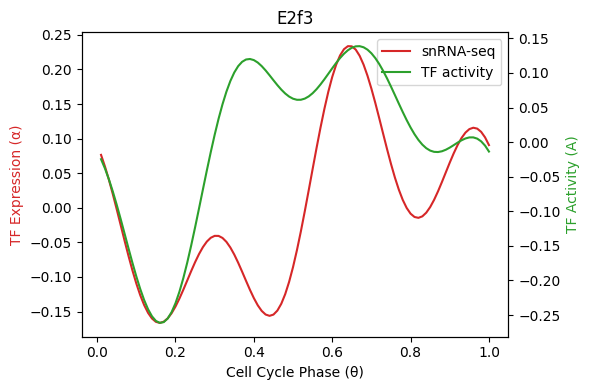

scRNA & A correlation : 0.458 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -5.79 (activator)


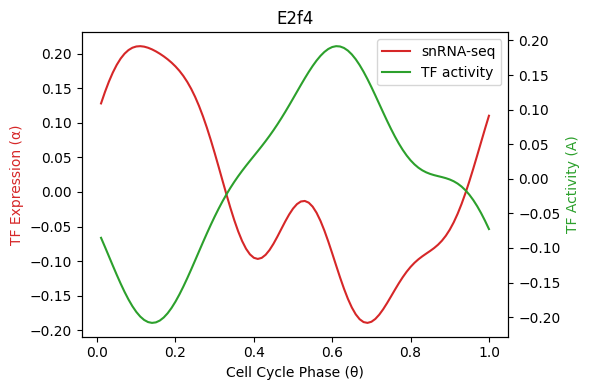

scRNA & A correlation : -0.835 (activator)

Expected activity range : [(0.01, 0.25)]
TF activity biological z-score : -16.54 (activator)


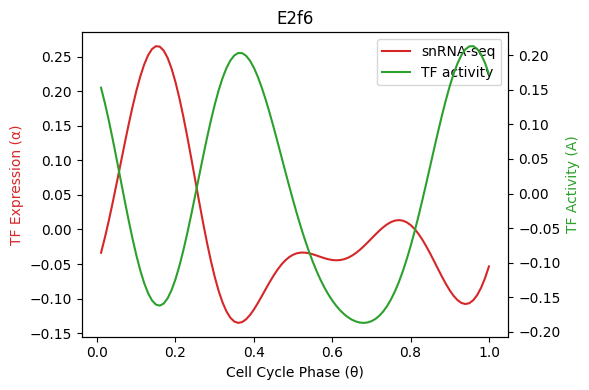

scRNA & A correlation : -0.667 (activator)

Expected activity range : [(0.01, 0.25), (0.63, 0.9)]
TF activity biological z-score : -6.54 (activator)


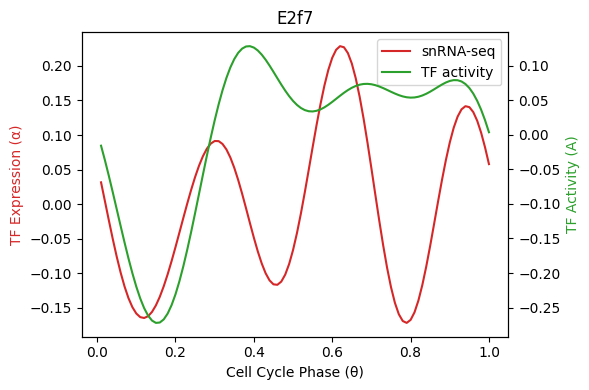

scRNA & A correlation : 0.267 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 6.76 (activator)


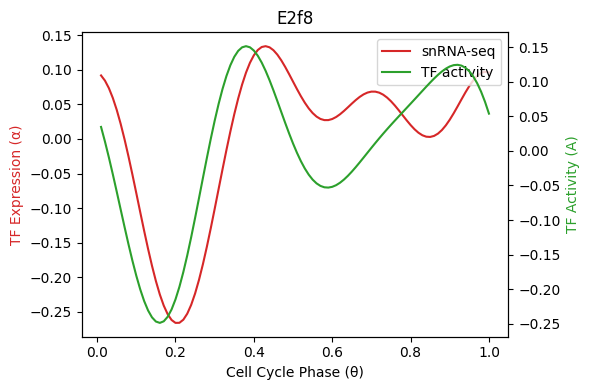

scRNA & A correlation : 0.573 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 3.14 (activator)


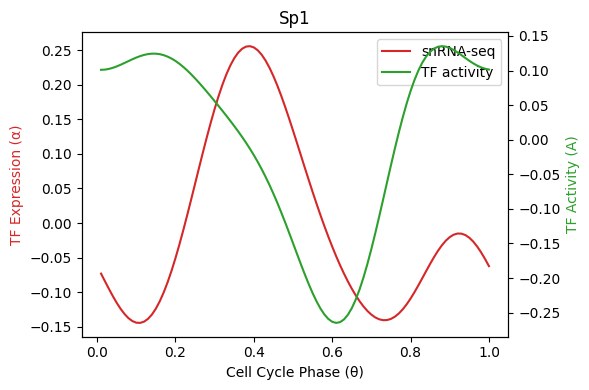

scRNA & A correlation : -0.241 (activator)

Expected activity range : [(0.1, 0.63)]
TF activity biological z-score : -2.48 (activator)


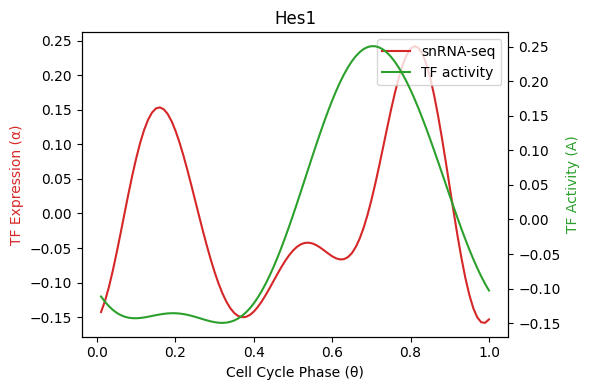

scRNA & A correlation : -0.278 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 17.85 (inhibitor)
Global correlation :-0.024
Global z-score :0.51


In [18]:
corrs = []
z_vals = []
for tf in range(len(tf_names_filtered)):
    plot_TF_exp_activity(theta_smooth, alpha_sn_norm, A_standard, tf_names, tf_names_filtered, tf)
    corr = spearmanr(alpha_sn_norm[tf], A_standard[list(tf_names).index(tf_names_filtered[tf])])[0]
    action = "activator" if not expected_activity[tf_names_filtered[tf]]["inhibitory"] else "inhibitor"
    if (action == "inhibitor"):
        corr = -corr
    print(f"scRNA & A correlation : {corr:.3f} ({ action })\n")
    z_val = compute_tf_activity_difference(A_standard[list(tf_names).index(tf_names_filtered[tf]), :], theta_smooth, expected_activity[tf_names_filtered[tf]]["ranges"], expected_activity[tf_names_filtered[tf]]["inhibitory"])
    corrs.append(corr)
    z_vals.append(z_val)
    print(f"Expected activity range : {expected_activity[tf_names_filtered[tf]]["ranges"]}")
    print(f"TF activity biological z-score : {z_val:.2f} ({ action })")
print(f"Global correlation :{np.mean(corrs):.3f}")
print(f"Global z-score :{np.mean(z_vals):.2f}")

In [19]:
#Demonstration that explained_variance_score calculate EV for columns (theta) and not rows (genes)
ev_per_gene = np.array([explained_variance_score(alpha1_norm[i], R[i]) for i in range(alpha1_norm.shape[0])])
ev_per_theta = np.array([explained_variance_score(alpha1_norm[:, j], R[:, j]) for j in range(alpha1_norm.shape[1])])
ev_global = explained_variance_score(alpha1_norm, R)

print(np.mean(ev_per_gene))
print(np.mean(ev_per_theta))
print(ev_global)

0.08452234485895106
0.12636041339240595
0.12636041339240575
